In [2]:
from keras.models import model_from_json
import pandas as pd
import numpy as np
from PIL import Image
import os
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.set_printoptions(threshold=sys.maxsize)

In [3]:
malware_family = ["Adialer.C", "Agent.FYI", "Allaple.A", "Allaple.L", "Alueron.gen!J", "Autorun.K", "C2LOP.gen!g",
                  "C2LOP.P", "Dialplatform.B", "Dontovo.A", "Fakerean", "Instantaccess", "Lolyda.AA1", "Lolyda.AA2",
                  "Lolyda.AA3", "Lolyda.AT", "Malex.gen!J", "Obfuscator.AD", "Rbot!gen", "Skintrim.N", "Swizzor.gen!E",
                  "Swizzor.gen!I", "VB.AT", "Wintrim.BX", "Yuner.A"]

malware_family1 = {"Adialer.C": 0, "Agent.FYI": 1, "Allaple.A": 2, "Allaple.L": 3, "Alueron.gen!J": 4, "Autorun.K": 5, "C2LOP.gen!g": 6,
                  "C2LOP.P": 7, "Dialplatform.B": 8, "Dontovo.A": 9, "Fakerean": 10, "Instantaccess": 11, "Lolyda.AA1": 12, "Lolyda.AA2": 13,
                  "Lolyda.AA3": 14, "Lolyda.AT": 15, "Malex.gen!J": 16, "Obfuscator.AD": 17, "Rbot!gen": 18, "Skintrim.N": 19, "Swizzor.gen!E": 20,
                  "Swizzor.gen!I": 21, "VB.AT": 22, "Wintrim.BX": 23, "Yuner.A": 24}

In [4]:
epochs = 20

# Load the json file that contains the model's structure
f = Path(f"artifacts/32x32/32x32_model_structure_{epochs}_epochs.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights(f"artifacts/32x32/32x32_model_weights_{epochs}_epochs.h5")

# Load an image file to test, resizing it to 32x32 pixels (as required by this model)
data = pd.read_excel("../../Dataset And Mapping/mapped-32x32-data.xlsx")

In [13]:
training_data_matrix = []
for el in np.array(data):
    if el[3] == "training":
        training_data_matrix.append(el)

x_train = []
y_train = []
y_train_indexes = []
i = 0
for it in training_data_matrix:
    i += 1
    im = Image.open(fr"../../Dataset And Mapping/{it[1]}")
    x_train.append(np.expand_dims((np.array(im) / 255), axis=2))
    y_temp = np.zeros(len(malware_family))
    y_temp[malware_family1[it[2]]] = 1
    y_train.append(y_temp)
    y_train_indexes.append(malware_family1[it[2]])
    # print(i)
    
y_train = np.array(y_train)


0


In [7]:
testing_data_matrix = []
for el in np.array(data):
    if el[3] == "testing":
        testing_data_matrix.append(el)

x_test = []
y_test = []
i = 0
for it in testing_data_matrix:
    i += 1
    im = Image.open(fr"../../Dataset And Mapping/{it[1]}")
    x_test.append(np.expand_dims((np.array(im) / 255), axis=2))
    y_test.append(malware_family.index(it[2]))
    # print(i)

y_test = np.array(y_test)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
# Convert the image to a numpy array
# image_to_test = image.img_to_array(img)
# image_to_test = np.expand_dims((np.array(img) / 255), axis=2)

# print(image_to_test.shape)


# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
# list_of_images = np.expand_dims(image_to_test, axis=0)
# list_of_images = np.expand_dims(x_test, axis=0)

# Make a prediction using the model
# results = model.predict(list_of_images)
# print(np.array(x_test).shape)
test_results = np.array(model.predict(np.array(x_test)))
train_results = np.array(model.predict(np.array(x_train)))

# Since we are only testing one image, we only need to check the first result
# single_result = results[0]

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
# most_likely_class_index = int(np.argmax(single_result))
test_most_likely_class_indexes = np.argmax(test_results, axis=1)
train_most_likely_class_indexes = np.argmax(train_results, axis=1)

In [7]:
test_results_comparison = test_most_likely_class_indexes == y_test
test_false_identification_indexes = np.where(np.logical_not(np.array(test_results_comparison)))[0]
test_count_true = np.count_nonzero(np.array(test_results_comparison))

In [8]:
train_results_comparison = train_most_likely_class_indexes == y_train_indexes
train_false_identification_indexes = np.where(np.logical_not(np.array(train_results_comparison)))[0]
train_count_true = np.count_nonzero(np.array(train_results_comparison))

In [9]:
test_success_rate = test_count_true / len(test_results_comparison)
train_success_rate = train_count_true / len(train_results_comparison)
print("Success rate:")
print("Train:", train_success_rate)
print("Test:", test_success_rate)

y_train_indexes_ = np.array(y_train_indexes)
y_test_ = np.array(y_test)

print("\nMalware family with the highest false classification:")
train_false_classification = np.array(malware_family)[y_train_indexes_[np.where((train_most_likely_class_indexes == y_train_indexes) == False)]]
labels, count = np.unique(train_false_classification, return_counts=True)
print("Train: ", labels[np.argmax(count)])

test_false_classification = np.array(malware_family)[y_test_[np.where((test_most_likely_class_indexes == y_test) == False)]]
labels, count = np.unique(test_false_classification, return_counts=True)
print("Test: ", labels[np.argmax(count)])

# print("Attention can be paid to the family which has the largest number of errors in identification:")
# print(y_test[test_false_identification_indexes])
# print(np.array(malware_family)[y_test[test_false_identification_indexes]])

Success rate:
Train: 0.9865556216537775
Test: 0.9775160599571735

Malware family with the highest false classification:
Train:  Autorun.K
Test:  Autorun.K


In [10]:
print(len(test_results_comparison))

934


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Adialer.C'),
  Text(1, 0, 'Agent.FYI'),
  Text(2, 0, 'Allaple.A'),
  Text(3, 0, 'Allaple.L'),
  Text(4, 0, 'Alueron.gen!J'),
  Text(5, 0, 'Autorun.K'),
  Text(6, 0, 'C2LOP.gen!g'),
  Text(7, 0, 'C2LOP.P'),
  Text(8, 0, 'Dialplatform.B'),
  Text(9, 0, 'Dontovo.A'),
  Text(10, 0, 'Fakerean'),
  Text(11, 0, 'Instantaccess'),
  Text(12, 0, 'Lolyda.AA1'),
  Text(13, 0, 'Lolyda.AA2'),
  Text(14, 0, 'Lolyda.AA3'),
  Text(15, 0, 'Lolyda.AT'),
  Text(16, 0, 'Malex.gen!J'),
  Text(17, 0, 'Obfuscator.AD'),
  Text(18, 0, 'Rbot!gen'),
  Text(19, 0, 'Skintrim.N'),
  Text(20, 0, 'Swizzor.gen!E'),
  Text(21, 0, 'Swizzor.gen!I'),
  Text(22, 0, 'VB.AT'),
  Text(23, 0, 'Wintrim.BX'),
  Text(24, 0, 'Yuner.A')])

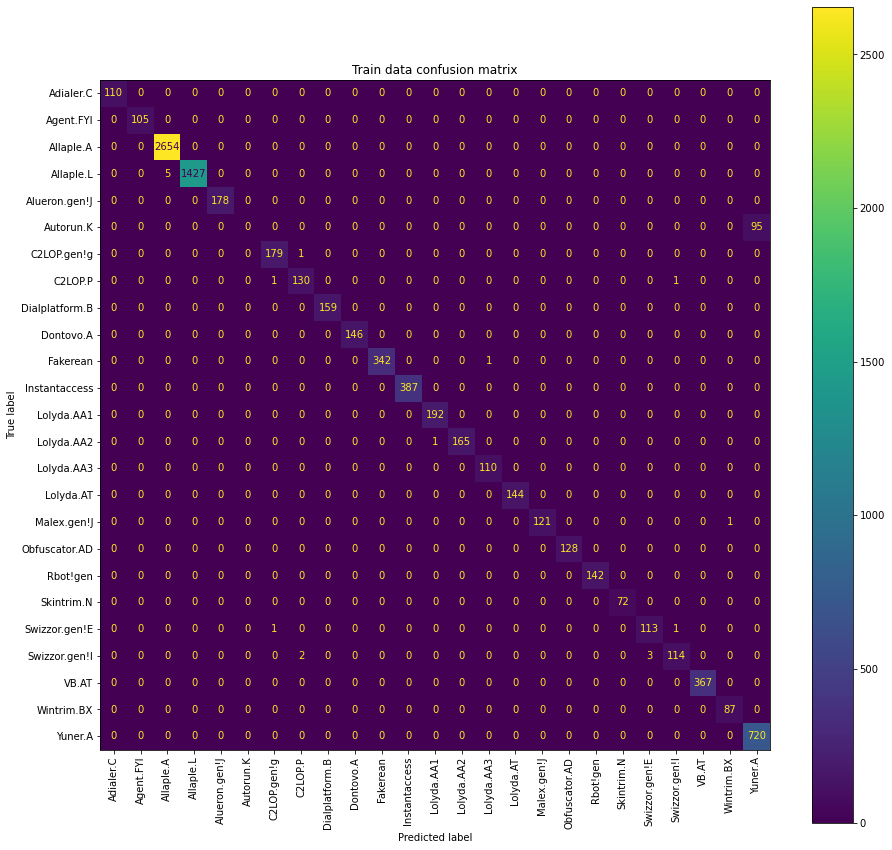

In [11]:
cm_train = metrics.confusion_matrix(y_train_indexes, train_most_likely_class_indexes)

cmp_train = metrics.ConfusionMatrixDisplay(cm_train, display_labels=malware_family)
fig, ax = plt.subplots(figsize=(15, 15))
cmp_train.plot(ax=ax)
plt.title('Train data confusion matrix')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Adialer.C'),
  Text(1, 0, 'Agent.FYI'),
  Text(2, 0, 'Allaple.A'),
  Text(3, 0, 'Allaple.L'),
  Text(4, 0, 'Alueron.gen!J'),
  Text(5, 0, 'Autorun.K'),
  Text(6, 0, 'C2LOP.gen!g'),
  Text(7, 0, 'C2LOP.P'),
  Text(8, 0, 'Dialplatform.B'),
  Text(9, 0, 'Dontovo.A'),
  Text(10, 0, 'Fakerean'),
  Text(11, 0, 'Instantaccess'),
  Text(12, 0, 'Lolyda.AA1'),
  Text(13, 0, 'Lolyda.AA2'),
  Text(14, 0, 'Lolyda.AA3'),
  Text(15, 0, 'Lolyda.AT'),
  Text(16, 0, 'Malex.gen!J'),
  Text(17, 0, 'Obfuscator.AD'),
  Text(18, 0, 'Rbot!gen'),
  Text(19, 0, 'Skintrim.N'),
  Text(20, 0, 'Swizzor.gen!E'),
  Text(21, 0, 'Swizzor.gen!I'),
  Text(22, 0, 'VB.AT'),
  Text(23, 0, 'Wintrim.BX'),
  Text(24, 0, 'Yuner.A')])

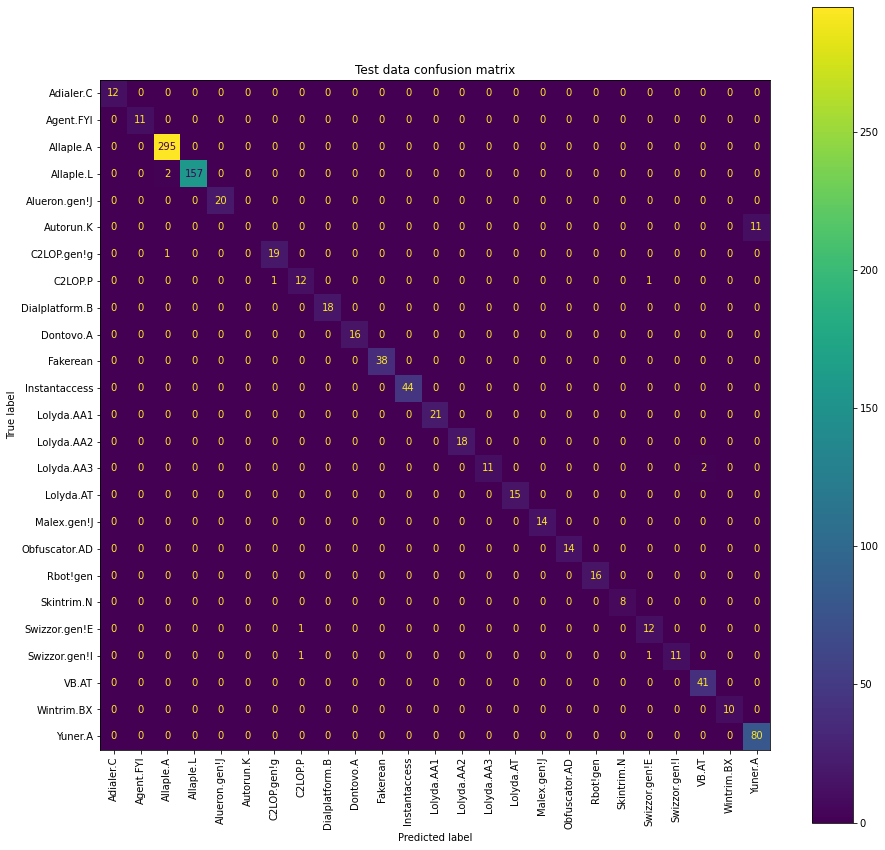

In [12]:
cm_test = metrics.confusion_matrix(y_test, test_most_likely_class_indexes)

cmp_test = metrics.ConfusionMatrixDisplay(cm_test, display_labels=malware_family)
fig, ax = plt.subplots(figsize=(15, 15))
cmp_test.plot(ax=ax)
plt.title('Test data confusion matrix')
plt.xticks(rotation=90)

In [13]:
train_labels, train_count = np.unique(y_train_indexes, return_counts=True)
train_accuracy_by_family = np.diag(cm_train) / train_count

test_labels, test_count = np.unique(y_test, return_counts=True)
test_accuracy_by_family = np.diag(cm_test) / test_count

print(train_accuracy_by_family)
print(test_accuracy_by_family)

[1.         1.         1.         0.99650838 1.         0.
 0.99444444 0.98484848 1.         1.         0.99708455 1.
 1.         0.9939759  1.         1.         0.99180328 1.
 1.         1.         0.9826087  0.95798319 1.         1.
 1.        ]
[1.         1.         1.         0.98742138 1.         0.
 0.95       0.85714286 1.         1.         1.         1.
 1.         1.         0.84615385 1.         1.         1.
 1.         1.         0.92307692 0.84615385 1.         1.
 1.        ]


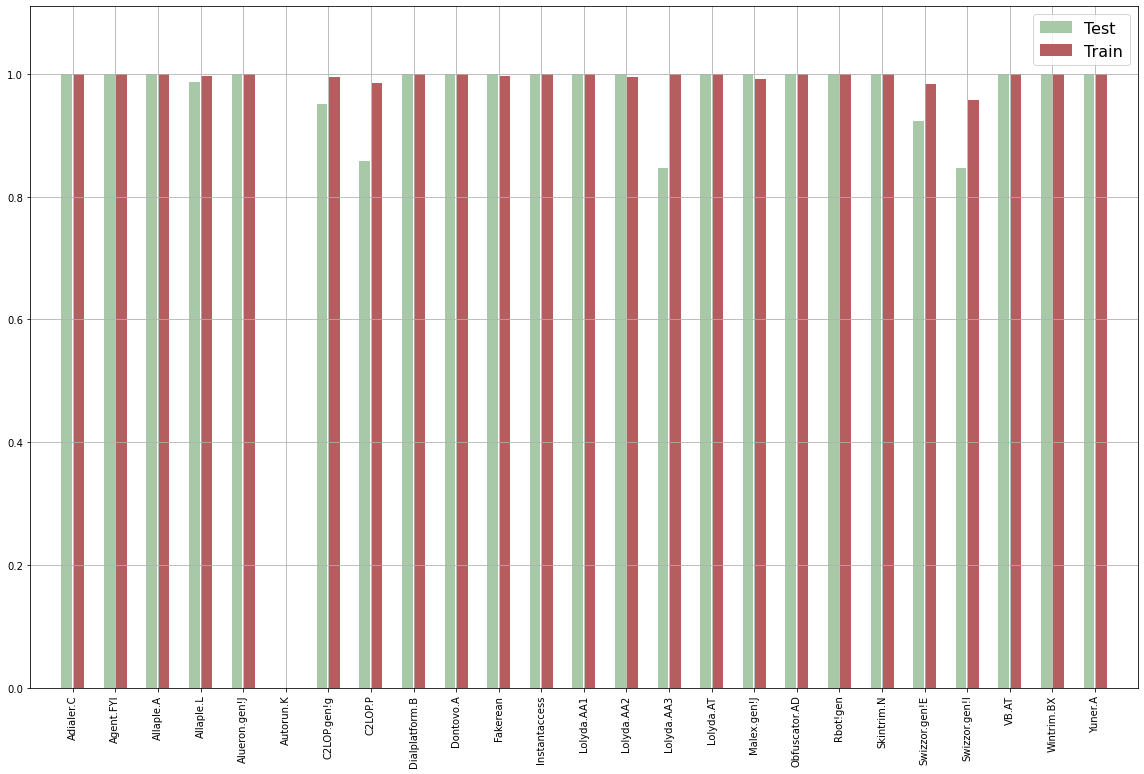

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))
labels = np.arange(len(malware_family))
width = 0.25
ax.bar(labels-width/2-0.02, test_accuracy_by_family, color="#a8c9a7", width=width, align='center')
ax.bar(labels+width/2+0.02, train_accuracy_by_family, color="#b55e5f", width=width, align='center')
fig.tight_layout()
ax.set_xticks(labels)
plt.xlim([-1, len(malware_family)])
ax.set_xticklabels(malware_family)
plt.xticks(rotation=90)
plt.legend(["Test", "Train"], prop={'size': 16})
plt.ylim([0, 1.11])
plt.grid(True)
plt.show()